In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from train import train
from train import train_rnis
from models_new import Renorm_Dynamic
from models_new import Rnis_Dynamic
from ei.EI_calculation import count_parameters
from dynamic_models_sis_new import Simple_Spring_Model
from datetime import datetime
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

# Generate data

In [3]:
# try another init part sample
experiments = 5
mul_batch_size = [0,10,4500,1500]
#mul_batch_size = [0,5000,3000,1000]
sigma = 0.03
rou = -0.5
steps = 7
sz = 4
scale = 2
L = 1
mae2_w = 3
T_total = 40001
dt = 0.01

eis_nis_e = np.zeros([experiments,T_total//500+1])
losses_nis_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_nis_e = np.zeros([experiments,T_total//500+1])
eis_nisp_e = np.zeros([experiments,T_total//500+1])
losses_nisp_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_nisp_e = np.zeros([experiments,T_total//500+1])
eis_rnis_e = np.zeros([experiments,T_total//500+1])
losses_rnis_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_rnis_e = np.zeros([experiments,T_total//500+1])

# Train RNIS

In [ ]:
# nis+
hidden_units_dyn = 32
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) #sir
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)
    
    eis_rnis, term1s_rnis, term2s_rnis, losses_rnis, MAEs_mstep_rnis, net_rnis = train_rnis(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, hidden_units_dyn = hidden_units_dyn, dt=dt, T2=T_total)
    eis_rnis_e[e,:] = eis_rnis
    losses_rnis_e[e,:] = losses_rnis
    MAEs_mstep_rnis_e[e,:] = MAEs_mstep_rnis

33312
check point-------o_0-> 12:27:48.592366; lasting 0:00:27.253360 seconds
Epoch: 0
Train loss: 0.5477
dEI: 0.4866
term1: -0.6551
term2: 1.6283
Test multistep loss: 1.5010
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 12:27:58.271678; lasting 0:00:09.679312 seconds
check point-------o_0-> 12:28:11.751517; lasting 0:00:13.479839 seconds
Epoch: 500
Train loss: 0.1162
dEI: 0.8328
term1: 0.1972
term2: 1.4684
Test multistep loss: 0.1414
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 12:28:20.746169; lasting 0:00:08.994652 seconds
check point-------o_0-> 12:28:33.920913; lasting 0:00:13.174744 seconds
Epoch: 1000
Train loss: 0.0439
dEI: 1.2703
term1: 1.1082
term2: 1.4325
Test multistep loss: 0.0844
--------------------------------------------------------------------------------------------------

# Train NIS

In [ ]:
# nis
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) 
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)
    
    eis_nis, term1s_nis, term2s_nis, losses_nis, MAEs_mstep_nis, net_nis= train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, dt=dt, T2=T_total,framework='nis')
    eis_nis_e[e,:] = eis_nis
    losses_nis_e[e,:] = losses_nis
    MAEs_mstep_nis_e[e,:] = MAEs_mstep_nis

# Train NIS+

In [ ]:
# nis+
for e in range(experiments):
    seed = 1 + e
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) #sir
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)
    
    eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp, net_nisp = train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, dt=dt, T2=T_total,framework='nis+')
    eis_nisp_e[e,:] = eis_nisp
    losses_nisp_e[e,:] = losses_nisp
    MAEs_mstep_nisp_e[e,:] = MAEs_mstep_nisp

# Results

In [13]:
print(count_parameters(net_rnis),count_parameters(net_nis),count_parameters(net_nisp))

33312 37404 37428


In [ ]:
np.save('results/eis_nis_e.npy', eis_nis_e)
np.save('results/losses_nis_e.npy', losses_nis_e)
np.save('results/MAEs_mstep_nis_e.npy', MAEs_mstep_nis_e)
np.save('results/eis_nisp_e.npy', eis_nisp_e)
np.save('results/losses_nisp_e.npy', losses_nisp_e)
np.save('results/MAEs_mstep_nisp_e.npy', MAEs_mstep_nisp_e)
np.save('results/eis_rnis_e.npy', eis_rnis_e)
np.save('results/losses_rnis_e.npy', losses_rnis_e)
np.save('results/MAEs_mstep_rnis_e.npy', MAEs_mstep_rnis_e)

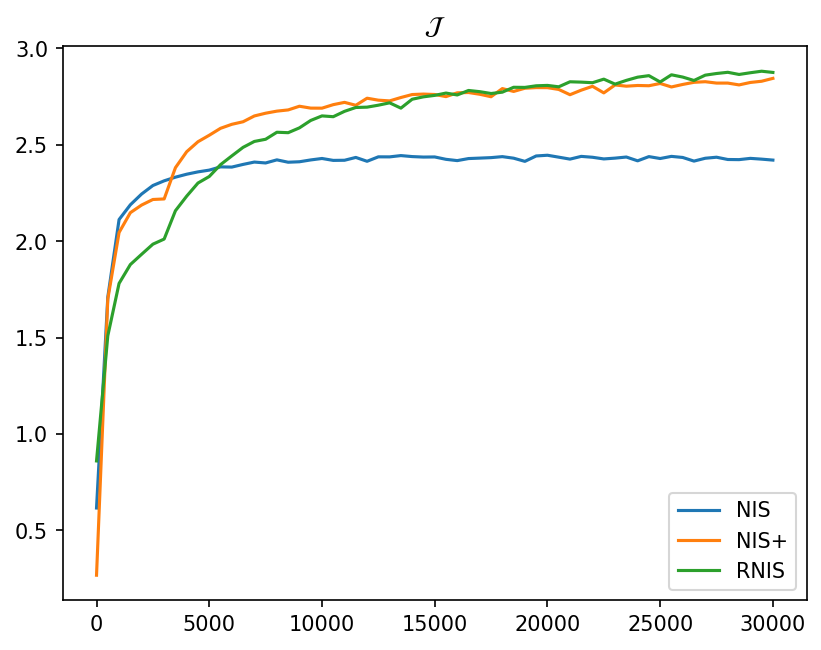

In [14]:
plt.figure(dpi=150)
timeseries = np.arange(len(eis_nis))*500
plt.plot(timeseries, eis_nis, label='NIS')
plt.plot(timeseries, eis_nisp, label='NIS+')
plt.plot(timeseries, eis_rnis, label='RNIS')
plt.title(r'$\mathcal{J}$')
plt.legend()
plt.show()

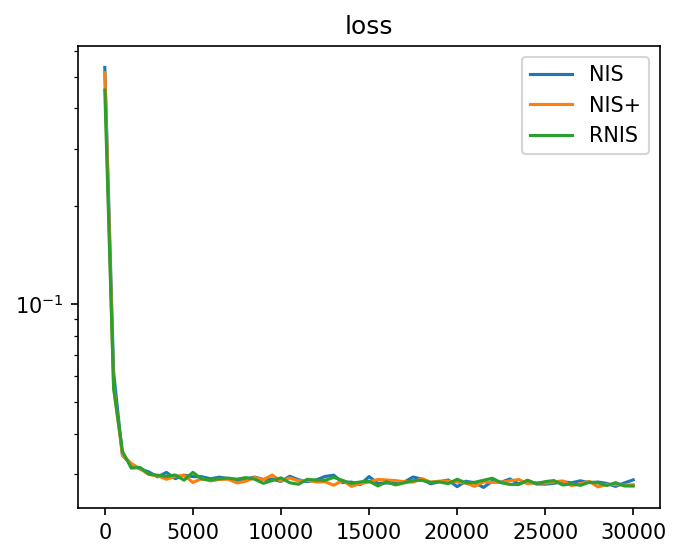

In [15]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis))*500
plt.plot(timeseries, losses_nis, label='NIS')
plt.plot(timeseries, losses_nisp, label='NIS+')
plt.plot(timeseries, losses_rnis, label='RNIS')
plt.title(r'loss')
plt.legend()
plt.yscale('log')
plt.show()

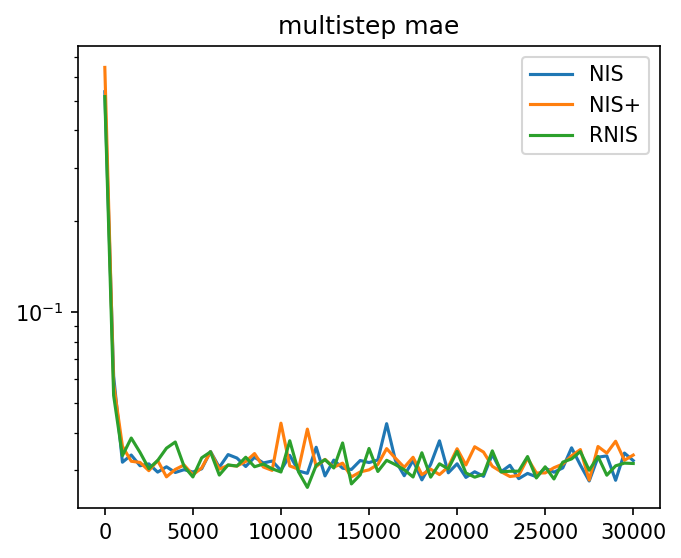

In [16]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis))*500
plt.plot(timeseries, MAEs_mstep_nis, label='NIS')
plt.plot(timeseries, MAEs_mstep_nisp, label='NIS+')
plt.plot(timeseries, MAEs_mstep_rnis, label='RNIS')
plt.title(r'multistep mae')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
for name, param in net_nisp.flow.named_parameters():
    print(name, param.data)

In [ ]:
for name, param in net_rnis.flow.named_parameters():
    print(name, param.data)